#  _Decision Tree Model for Binary classification_

## _Problem_

Identify products at risk of backorder before the event occurs so the business has time to react. 

#### _Loading the required libraries_

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

import graphviz
#!conda install -c conda-forge python-graphviz
#!conda install --yes python-graphviz
#!conda install --yes graphviz

### _Data_

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.
    
         Yes or 1 : Product backordered

         No or 0  : Product not backordered

#### Loading the data

In [2]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the No. row and columns

In [3]:
data.shape

(61589, 23)

Display the columns

In [4]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [5]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [6]:
data[:3]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe

In [7]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [8]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

In [9]:
data.describe(include='object')

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,61589,61589,61589,61589,61589,61589,61589
unique,2,2,2,2,2,2,2
top,No,No,No,No,Yes,No,No
freq,61509,48145,61577,53792,59303,61569,50296


#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [10]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [11]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

#### Delete sku attribute

In [12]:
len(data.sku.unique())

61589

In [13]:
data.drop('sku', axis=1, inplace=True)

Seperating categorical and numeric attributes

In [14]:
categorical_Attributes = list(data.select_dtypes(include=['category']).columns)
categorical_Attributes.pop()

'went_on_backorder'

In [15]:
categorical_Attributes

['potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop']

In [16]:
numerical_Attributes = list(data.columns.difference(categorical_Attributes))
numerical_Attributes.pop()

'went_on_backorder'

In [17]:
numerical_Attributes

['forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'in_transit_qty',
 'lead_time',
 'local_bo_qty',
 'min_bank',
 'national_inv',
 'perf_12_month_avg',
 'perf_6_month_avg',
 'pieces_past_due',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month']

# With Pipeline

## Sklearn pipelines

Pipelines are a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code.

Pipelines are set up with the fit/transform/predict functionality, so you can fit a whole pipeline to the training data and transform to the test data, without having to do it individually for each thing you do. Super convenienent, right?

Steps to follow to create a pipeline

Step 1) Fetch the numerical and categorical columns

Step 2) Create a transformer/pipeline for numerical attributes

    Create a list of tuples where each tuple represents the operation to be performed on numerical attributes

Step 3) Create a transformer/pipeline for categorical attributes

    Create a list of tuples where each tuple represent the operation to be performed on categorical attributes

Step 4) Create a ColumnTransformer which merges both the numerical and categorical transformers

Step5) Create a final pipeline object which includes the ColumnTransformer and an estimator (an algorithm to be build on dataset)

Step6) (optional) Create a GridSearchCV object with pipeline as one of the inputs along with hyperparameter grid and Cross validation object

Step7) Apply fit() on train data and predict() on test data <br><br>

**TL; DR**
Pipeline is a collection of transformers chained together and operate sequentially. (often ending with an estimator)

__Bird's view of sklearn pipeline__

<img src="Pipeline_broadview.png"><br><br>

__Train and Test dataflow inside the sklearn pipeline__
<img src="fit_tranform.jpg">

#### Split the data in to train and test

sklearn.model_selection.train_test_split

    Split arrays or matrices into random train and test subsets

In [18]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder'], data.loc[:,'went_on_backorder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [19]:
def convert_for_sklearn(label_list):
    return [1 if i == 'Yes' else 0 for i in label_list]
y_train = convert_for_sklearn(y_train)
y_test = convert_for_sklearn(y_test)

#### _Instantiate Pre-processing Objects for Pipeline_

In [20]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent',fill_value="missing_value")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_Attributes),
        ('cat', categorical_transformer, categorical_Attributes)])

#### _Instantiate Pipeline Object_

In [21]:
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', tree.DecisionTreeClassifier())])

### _Build Logistic Regression Model - 1_

In [22]:
clf_dt.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

### _Evaluate Model_

In [23]:
train_pred = clf_dt.predict(X_train)
test_pred = clf_dt.predict(X_test)

In [24]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[35193    24]
 [   80  7815]]
[[14093   986]
 [  774  2624]]


In [25]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR or Specificity:  0.9993185109464179
Train TPR or Recall:  0.9898670044331855
Train Accuracy:  0.9975876786045649


In [26]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR or Specificity: ",TNR_Test)
print("Test TPR or Recall: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR or Specificity:  0.9346110484780158
Test TPR or Recall:  0.772218952324897
Test Accuracy:  0.9047464415218921


# Without Pipeline

In [27]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

In [28]:
#data.lead_time.mean()
data['lead_time']=data.lead_time.fillna(data.lead_time.median())

In [29]:
data.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

#### Converting Categorical to Numeric

    'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables

In [30]:
data = pd.get_dummies(columns=categorical_Attributes, data=data)

In [31]:
data.dtypes

national_inv              int64
lead_time               float64
in_transit_qty            int64
forecast_3_month          int64
forecast_6_month          int64
forecast_9_month          int64
sales_1_month             int64
sales_3_month             int64
sales_6_month             int64
sales_9_month             int64
min_bank                  int64
pieces_past_due           int64
perf_6_month_avg        float64
perf_12_month_avg       float64
local_bo_qty              int64
went_on_backorder      category
potential_issue_No        uint8
potential_issue_Yes       uint8
deck_risk_No              uint8
deck_risk_Yes             uint8
oe_constraint_No          uint8
oe_constraint_Yes         uint8
ppap_risk_No              uint8
ppap_risk_Yes             uint8
stop_auto_buy_No          uint8
stop_auto_buy_Yes         uint8
rev_stop_No               uint8
rev_stop_Yes              uint8
dtype: object

In [32]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder'], data.loc[:,'went_on_backorder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### _Building a  Basic Decision Tree Model_

In [33]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

### _Test Performance_

In [34]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

#### _Getting evaluation metrics and evaluating model performance_

In [35]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[35193    24]
 [   80  7815]]
[[14076  1003]
 [  777  2621]]


#### _Calculate Accuracy, True Positive Rate and True Negative Rates_

In [36]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR or Specificity:  0.9993185109464179
Train TPR or Recall:  0.9898670044331855
Train Accuracy:  0.9975876786045649


In [37]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR or Specificity: ",TNR_Test)
print("Test TPR or Recall: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR or Specificity:  0.9334836527621195
Test TPR or Recall:  0.7713360800470865
Test Accuracy:  0.9036640147210044


### Extracting the important features

In [38]:
clf.feature_importances_

array([2.57755538e-01, 2.77365338e-02, 2.96891686e-02, 2.41138796e-01,
       3.21187622e-02, 3.43108535e-02, 6.69632593e-02, 3.20642073e-02,
       4.20709819e-02, 4.95153759e-02, 2.79145078e-02, 7.80479703e-03,
       5.57903043e-02, 6.35133838e-02, 7.84234231e-03, 0.00000000e+00,
       1.98561090e-04, 6.40803942e-03, 5.31144388e-03, 0.00000000e+00,
       0.00000000e+00, 5.62683467e-03, 3.93682463e-03, 7.87205729e-04,
       1.43171301e-03, 7.05656536e-05, 0.00000000e+00])

In [39]:
features = data.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] # np.argsort returns the indices that would sort an array.
pd.DataFrame([data.columns[indices],np.sort(importances)[::-1]])

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,national_inv,forecast_3_month,sales_1_month,perf_12_month_avg,perf_6_month_avg,sales_9_month,sales_6_month,forecast_9_month,forecast_6_month,sales_3_month,...,deck_risk_No,ppap_risk_No,stop_auto_buy_No,ppap_risk_Yes,potential_issue_No,stop_auto_buy_Yes,went_on_backorder,deck_risk_Yes,oe_constraint_No,rev_stop_No
1,0.257756,0.241139,0.0669633,0.0635134,0.0557903,0.0495154,0.042071,0.0343109,0.0321188,0.0320642,...,0.00531144,0.00393682,0.00143171,0.000787206,0.000198561,7.05657e-05,0,0,0,0


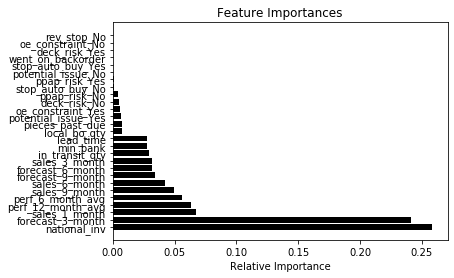

In [40]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Building Decision Tree Model using Variable Importance

In [41]:
select = indices[0:10]
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train.iloc[:,select], y_train)

In [42]:
train_pred = clf.predict(X_train.iloc[:,select])
test_pred = clf.predict(X_test.iloc[:,select])

#### Getting evaluation metrics and evaluating model performance

In [43]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[34101  1116]
 [ 4540  3355]]
[[14573   506]
 [ 1974  1424]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [44]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR or Specificity:  0.9683107590084334
Train TPR or Recall:  0.4249525015832806
Train Accuracy:  0.8688068287251809


In [45]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR or Specificity: ",TNR_Test)
print("Test TPR or Recall: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR or Specificity:  0.9664433981033225
Test TPR or Recall:  0.4190700412007063
Test Accuracy:  0.8657790766899388


### _How do we arrive at the best tree depth for this data?_

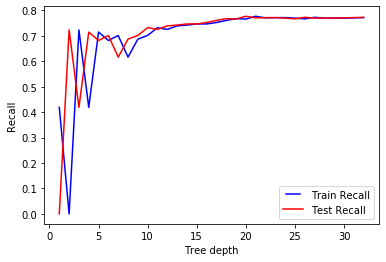

In [46]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    confusion_matrix_train = confusion_matrix(y_train, train_pred)
    recall_Train=confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])
    train_results.append(recall_Train)
    
    test_pred = dt.predict(X_test)
    confusion_matrix_test = confusion_matrix(y_test, test_pred)
    recall_Test=confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])
    test_results.append(recall_Test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results,'b', label='Train Recall')
line2, = plt.plot(max_depths, test_results,'r', label='Test Recall')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Recall')
plt.xlabel('Tree depth')
plt.show()

### _Is there a better way to tune Hyper-parameters?_

<br />

_Lets list the hyper-parameters for Decision Trees:_

**criterion** : string, optional (default=”gini”)
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.


**max_depth** : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


**min_samples_split** : int, float, optional (default=2)
The minimum number of samples required to split an internal node:
If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.



**min_samples_leaf** : int, float, optional (default=1)
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

**max_leaf_nodes** : int or None, optional (default=None)
Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.


In [46]:
# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [5, 10, 20],
              "max_depth": [2, 5, 10, 15, 30],
              #"min_samples_leaf": [5, 10],
              "max_leaf_nodes": [100, 120, 135, 150],
              }

In [47]:
dt = tree.DecisionTreeClassifier()
clf2 = GridSearchCV(dt, param_grid, cv=10)
clf2.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 15, 30],
                  

In [48]:
clf2.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
                       max_features=None, max_leaf_nodes=150,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [49]:
train_pred = clf2.predict(X_train)
test_pred = clf2.predict(X_test)

In [50]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)
print("\n")

Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR or Specificity: ",TNR_Test)
print("Test TPR or Recall: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Train TNR or Specificity:  0.9568390266064685
Train TPR or Recall:  0.7271690943635212
Train Accuracy:  0.9147801076266469


Test TNR or Specificity:  0.9504609058956164
Test TPR or Recall:  0.7042377869334903
Test Accuracy:  0.9051794122422471


## _Visualizing Decision Trees_

In [51]:
dot_data = tree.export_graphviz(clf2.best_estimator_,
                                feature_names=data.drop(['went_on_backorder'], axis = 1).columns,
                                class_names=['No','Yes'], 
                                filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph
graph.render("back_orders") 

'back_orders.pdf'

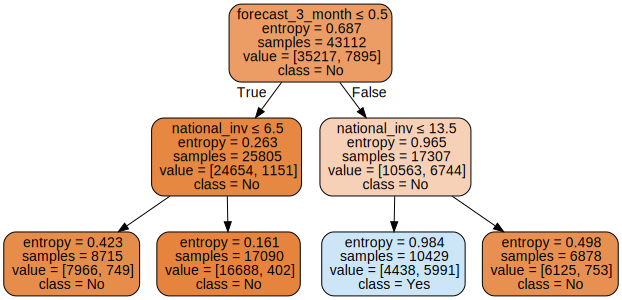

In [58]:
dot_data = tree.export_graphviz(clf2.best_estimator_,
                                feature_names=data.drop(['went_on_backorder'], axis = 1).columns,
                                class_names=['No','Yes'], 
                                filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph
#graph.render("back_orders") 

In [52]:
def convert_for_sklearn(label_list):
    return [1 if i == 'Yes' else 0 for i in label_list]
y_train = convert_for_sklearn(y_train)
y_test = convert_for_sklearn(y_test)

In [53]:
dt = tree.DecisionTreeClassifier()
clf2 = GridSearchCV(dt, param_grid, cv=10, scoring='recall')
clf2.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 15, 30],
                  

In [54]:
clf2.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [55]:
train_pred = clf2.predict(X_train)
test_pred = clf2.predict(X_test)

In [56]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR or Specificity: ",TNR_Test)
print("Test TPR or Recall: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Train TNR or Specificity:  0.873981315841781
Train TPR or Recall:  0.7588347055098164
Train Accuracy:  0.8528947856745221
Test TNR or Specificity:  0.8724053319185623
Test TPR or Recall:  0.7519128899352561
Test Accuracy:  0.850246252097202
